# GPT2 Inference and Loading Setup

GPT2 has four models from 124M to 1.5B

We'll focus on 124M. The 124M model has 12 layers and 768 embedding dimension.

To load the pre-trained GPT2, the names of the parameters of each component(things like TransformerBlock, Attention) must match the hugging face names. First, we'll analyze these names, and then build the instantiation of the GPT(without any internal logic).

In [43]:
from tinygrad import Tensor, dtypes
from tinygrad.nn import Embedding, Linear, LayerNorm
from tinygrad.nn.state import torch_load, load_state_dict, get_state_dict, get_parameters
from tqdm import tqdm, trange
from tinygrad.nn.optim import AdamW
from dataclasses import dataclass
from tinygrad.helpers import fetch
import tiktoken
import numpy as np
import os
import matplotlib.pyplot as plt

In [44]:
weights = torch_load(fetch(f'https://huggingface.co/gpt2/resolve/main/pytorch_model.bin'))
get_state_dict(weights).keys()

dict_keys(['wte.weight', 'wpe.weight', 'h.0.ln_1.weight', 'h.0.ln_1.bias', 'h.0.attn.bias', 'h.0.attn.c_attn.weight', 'h.0.attn.c_attn.bias', 'h.0.attn.c_proj.weight', 'h.0.attn.c_proj.bias', 'h.0.ln_2.weight', 'h.0.ln_2.bias', 'h.0.mlp.c_fc.weight', 'h.0.mlp.c_fc.bias', 'h.0.mlp.c_proj.weight', 'h.0.mlp.c_proj.bias', 'h.1.ln_1.weight', 'h.1.ln_1.bias', 'h.1.attn.bias', 'h.1.attn.c_attn.weight', 'h.1.attn.c_attn.bias', 'h.1.attn.c_proj.weight', 'h.1.attn.c_proj.bias', 'h.1.ln_2.weight', 'h.1.ln_2.bias', 'h.1.mlp.c_fc.weight', 'h.1.mlp.c_fc.bias', 'h.1.mlp.c_proj.weight', 'h.1.mlp.c_proj.bias', 'h.2.ln_1.weight', 'h.2.ln_1.bias', 'h.2.attn.bias', 'h.2.attn.c_attn.weight', 'h.2.attn.c_attn.bias', 'h.2.attn.c_proj.weight', 'h.2.attn.c_proj.bias', 'h.2.ln_2.weight', 'h.2.ln_2.bias', 'h.2.mlp.c_fc.weight', 'h.2.mlp.c_fc.bias', 'h.2.mlp.c_proj.weight', 'h.2.mlp.c_proj.bias', 'h.3.ln_1.weight', 'h.3.ln_1.bias', 'h.3.attn.bias', 'h.3.attn.c_attn.weight', 'h.3.attn.c_attn.bias', 'h.3.attn.c_pro

Transformer-Level Names:
* Token Embedding(weight only) = `wte`
* Positional Embedding(weight only) = `wpe`
* Transformer Block(see below) at layer `n` = `h.n`
* Final Layer-Norm(weight+bias): `ln_f`

Notice there is no logit head at the end. This is because GPT2 shares the token embedding and output head. To be able to use lm_head with the correct weights, we have to manually set this.

I've also noticed there's a `bias` for each attention block representing the attention mask. We don't need this, and TinyGrad will automatically ignore it when loading weights. 

Transformer-Block Names:
* Attention Pre-Norm(weight+bias): `ln_1`
* Attention(see below): `attn`
* MLP Pre-Norm(weight+bias): `mlp`
* MLP(see below): `mlp`

Attention Names:
* QKV projection(weight+bias): `c_attn`
* Output Projection(weight+bias): `c_proj`

MLP Names:
* Expansion Projection(weight+bias): `c_fc`
* Compression Projection(weight+bias): `c_proj`

In [45]:
@dataclass
class GPT2Config:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    norm_eps: float = 1e-5

@dataclass
class GPT2Small(GPT2Config):
    pass

@dataclass
class GPT2Medium(GPT2Config):
    n_layer: int = 24
    n_head: int = 16
    n_embd: int = 1024

@dataclass
class GPT2Large(GPT2Config):
    n_layer: int = 36
    n_head: int = 20
    n_embd: int = 1280

@dataclass
class GPT2XL(GPT2Config):
    n_layer: int = 48
    n_head: int = 25
    n_embd: int = 1600
    
MODEL_CONFIGS = {
    'gpt2': GPT2Small,
    'gpt2-medium': GPT2Medium,
    'gpt2-large': GPT2Large,
    'gpt2-xl': GPT2XL
}

class Attention:
    def __init__(self, config : GPT2Config):
        self.c_attn = Linear(config.n_embd, config.n_embd*3)
        self.c_proj = Linear(config.n_embd, config.n_embd)

class MLP:
    def __init__(self, config : GPT2Config):
        self.c_fc = Linear(config.n_embd, config.n_embd*4)
        self.c_proj = Linear(config.n_embd*4, config.n_embd)

class TransformerBlock:
    def __init__(self, config : GPT2Config):
        self.ln_1 = LayerNorm(config.n_embd, eps=config.norm_eps)
        self.ln_2 = LayerNorm(config.n_embd, eps=config.norm_eps)
        self.attn = Attention(config)
        self.mlp = MLP(config)

class GPT2:
    def __init__(self, config : GPT2Config):
        self.config = config

        # self.decoder = []
        self.wte = Embedding(config.vocab_size, config.n_embd)
        self.wpe = Embedding(config.block_size, config.n_embd)
        self.h = [TransformerBlock(config) for _ in range(config.n_layer)]
        self.ln_f = LayerNorm(config.n_embd, eps=config.norm_eps)
        self.lm_head = Linear(config.n_embd, config.vocab_size, bias=False)

        self.wte.weight = self.lm_head.weight

    @staticmethod
    def build(MODEL_NAME):
        
        weights = torch_load(fetch(f'https://huggingface.co/{MODEL_NAME}/resolve/main/pytorch_model.bin'))
        weights['lm_head.weight'] = weights['wte.weight']

        # I believe this is necessary because TinyGrad linear matmul acts on the other side
        transposed = ('attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight')
        for k in weights:
            if k.endswith(transposed):
                weights[k] = weights[k].T

        return load_state_dict(GPT2(MODEL_CONFIGS[MODEL_NAME]), weights)

In [46]:
GPT2.build('gpt2')

ram used:  5.35 GB, lm_head.weight                                    : 100%|██████████| 149/149 [00:00<00:00, 225.32it/s]

loaded weights in 663.70 ms, 0.65 GB loaded at 0.98 GB/s


Now that the we can load the parameters, let's get into the implementation of each component. The MLP is simplest, so that's a good starting point.

In [47]:
class MLP:
    def __init__(self, config : GPT2Config):
        self.c_fc = Linear(config.n_embd, config.n_embd*4)
        self.c_proj = Linear(config.n_embd*4, config.n_embd)
    def __call__(self, x):
        x = self.c_fc(x).gelu()
        x = self.c_proj(x)
        return x

Next is Attention, Multi-Headed Attention that is.

In [48]:
class Attention:
    def __init__(self, config: GPT2Config):
        self.config = config
        self.c_attn = Linear(config.n_embd, config.n_embd*3)
        self.c_proj = Linear(config.n_embd, config.n_embd)
    def __call__(self, x):
        B,T,C = x.shape

        q, k, v = self.c_attn(x).split(C, dim=-1) #(B,T,3C) -> (B,T,C) x 3
        split_heads = lambda x: x.view(B, T, self.config.n_head, self.config.n_embd//self.config.n_head).transpose(1,2)
        q, k, v = map(split_heads, (q,k,v))

        y = q.scaled_dot_product_attention(k, v, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)

        return y

Then the transformer block, which is fairly simple.

In [49]:
class TransformerBlock:
    def __init__(self, config : GPT2Config):
        self.ln_1 = LayerNorm(config.n_embd, eps=config.norm_eps)
        self.ln_2 = LayerNorm(config.n_embd, eps=config.norm_eps)
        self.attn = Attention(config)
        self.mlp = MLP(config)
    def __call__(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

And finishing it off with our GPT2 class.

In [50]:
class GPT2:
    def __init__(self, config : GPT2Config = GPT2Small):
        self.config = config

        self.wte = Embedding(config.vocab_size, config.n_embd)
        self.wpe = Embedding(config.block_size, config.n_embd)
        self.h = [TransformerBlock(config) for _ in range(config.n_layer)]
        self.ln_f = LayerNorm(config.n_embd, config.norm_eps)
        self.lm_head = Linear(config.n_embd, config.vocab_size, bias=False)

        # tie weights - HUGE SAVINGS
        self.lm_head.weight = self.wte.weight
    
    
    def __call__(self, idx):
        B,T = idx.shape

        assert T <= self.config.block_size, f"Cannot forward, model block size is {self.config.block_size} but got sequence of length {T}"
        pos = Tensor.arange(0, T, dtype=dtypes.long) # (T,)
        pos_emb = self.wpe(pos) # (T,) -> (T,C)
        tok_emb = self.wte(idx) # (B,T) -> (B,T,C)

        x = tok_emb + pos_emb
        x = x.sequential(self.h)

        x = self.ln_f(x)
        logits = self.lm_head(x) # (B,T,C) -> (B,T,V)

        return logits

    @staticmethod
    def build(MODEL_NAME):
        
        weights = torch_load(fetch(f'https://huggingface.co/{MODEL_NAME}/resolve/main/pytorch_model.bin'))

        transposed = ('attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight')
        for k in weights:
            if k.endswith(transposed):
                weights[k] = weights[k].T

        weights['lm_head.weight'] = weights['wte.weight']
        model = GPT2(MODEL_CONFIGS[MODEL_NAME])
        load_state_dict(model, weights)

        return model

In [51]:
# taken from https://github.com/tinygrad/tinygrad/blob/97b05f567e8e42a2475f8a063fb080b200f6f033/extra/models/mask_rcnn.py
def topk(input_, k, dim=-1, largest=True, sorted=False):
  k = min(k, input_.shape[dim]-1)
  input_ = input_.numpy()
  if largest: input_ *= -1
  ind = np.argpartition(input_, k, axis=dim)
  if largest: input_ *= -1
  ind = np.take(ind, np.arange(k), axis=dim) # k non-sorted indices
  input_ = np.take_along_axis(input_, ind, axis=dim) # k non-sorted values
  if not sorted: return Tensor(input_), Tensor(ind)
  if largest: input_ *= -1
  ind_part = np.argsort(input_, axis=dim)
  ind = np.take_along_axis(ind, ind_part, axis=dim)
  if largest: input_ *= -1
  val = np.take_along_axis(input_, ind_part, axis=dim)
  return Tensor(val), Tensor(ind)

In [52]:
num_return_sequences = 5
max_length = 30

enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode("What is the meaning of life?")
x = Tensor(tokens, dtype=dtypes.long).unsqueeze(0).repeat(num_return_sequences, 1)

model = GPT2.build('gpt2-large')

#does this do anything?
Tensor.no_grad = True
Tensor.training = False
while x.shape[1] < max_length:
    logits = model(x)
    logits = logits[:, -1, :]
    probs = logits.softmax(-1)
    topk_probs, topk_indices = topk(probs, 50, dim=-1)
    ix = topk_probs.multinomial(1)
    xcol = topk_indices.gather(-1, ix)
    x = x.cat(xcol, dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].numpy().tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

ram used:  7.94 GB, lm_head.weight                                    : 100%|██████████| 437/437 [00:01<00:00, 255.50it/s]


loaded weights in 1712.19 ms, 3.35 GB loaded at 1.96 GB/s
> What is the meaning of life? What is our purpose in this world? Is there another meaning?" In terms of the meaning of life, the answer
> What is the meaning of life? What is God? What is eternity? When did Adam first become alive? Does God exist? Is God a being
> What is the meaning of life? How does the life of a human being and all of its consequences and results mean to us? How can it be
> What is the meaning of life?

Well, how in the world are you going to survive?

What is life?

Well
> What is the meaning of life?

Some people may claim that there is nothing to live for but a mere struggle for existence, a contest for


# **YES!**

Let's try random init.

In [12]:
num_return_sequences = 5
max_length = 30

enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode("Hello, I'm a language model,")
x = Tensor(tokens, dtype=dtypes.long).unsqueeze(0).repeat(num_return_sequences, 1)

model = GPT2(GPT2Small)

#does this do anything?
Tensor.no_grad = True
Tensor.training = False
while x.shape[1] < max_length:
    logits = model(x)
    logits = logits[:, -1, :]
    probs = logits.softmax(-1)
    topk_probs, topk_indices = topk(probs, 50, dim=-1)
    ix = topk_probs.multinomial(1)
    xcol = topk_indices.gather(-1, ix)
    x = x.cat(xcol, dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].numpy().tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, Yellowstone naughtyagic problemsStrong Intakeleaf quantify� Intake Debate Winchester Frem wrestling stations sufficiently 裏覚醒 drying Tut Tut stations practitioners
> Hello, I'm a language model,ngagicticksized Cheneyleafahah starved Ubisoft sufficiently naughty stations Zac neb Yor Ubisoft Marineng Lob substantial denounced coincides
> Hello, I'm a language model,Workhair Khalid projectingames Ubisoftfollow proceeded quantifyStrong stations resignation WinchesterleafCloseGhostGhost problems Kelley Winchester needless righteousness
> Hello, I'm a language model, Khalid naughtytickWorkahah Yellowstone relief quantify Marine sufficiently resignationran tigers stationsbalance Theater neb Accountabilityogh Tut Debate join
> Hello, I'm a language model, Tut Marineagic mob relief wrestling?!" Debate Marineng neb applause TutWorktick sufficiently extravag Yellowstone illuminatingng Marine pathology


# Training

To begin, we'll need some data to train on. We'll load up the tiny-shakespeare dataset in classic karpathy style.

In [13]:
with open("../datasets/shake.txt", "r") as f:
    text = f.read()
data = text[:1000]
encoded_data = enc.encode(data)
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


Using `view` allows us to quickly text into (B,T) sequences. As you can see, it lays things out side by side. `reshape` would do the same.

For every batch `B` of text with length `T`, we need to retrieve `B*T+1`.

In [14]:
buf = Tensor(encoded_data[:24+1])
batch = lambda x: x.view(4,6)
x = batch(buf[:-1])
y = batch(buf[1:])
print(x.numpy(),y.numpy())

[[ 5962 22307    25   198  8421   356]
 [ 5120   597  2252    11  3285   502]
 [ 2740    13   198   198  3237    25]
 [  198  5248   461    11  2740    13]] [[22307    25   198  8421   356  5120]
 [  597  2252    11  3285   502  2740]
 [   13   198   198  3237    25   198]
 [ 5248   461    11  2740    13   198]]


Instead of including the loss calculation in some external training method, we can directly adapt the forward pass to accept labels and return the loss (as well as logits like we've already done).

`logits` will have shape `(B,T,V)` and targets will be `(B,T)`. `sparse_categorical_crossentropy` requires the input to be `(N, num_classes)`, where `num_classes` is `V` in our case.

In [56]:
class GPT2:
    def __init__(self, config : GPT2Config = GPT2Small):
        self.config = config

        self.wte = Embedding(config.vocab_size, config.n_embd)
        self.wpe = Embedding(config.block_size, config.n_embd)
        self.h = [TransformerBlock(config) for _ in range(config.n_layer)]
        self.ln_f = LayerNorm(config.n_embd, config.norm_eps)
        self.lm_head = Linear(config.n_embd, config.vocab_size, bias=False)

        # tie weights - HUGE SAVINGS
        self.lm_head.weight = self.wte.weight
    
    def __call__(self, idx, targets=None):
        B,T = idx.shape

        assert T <= self.config.block_size, f"Cannot forward, model block size is {self.config.block_size} but got sequence of length {T}"
        pos = Tensor.arange(0, T, dtype=dtypes.long) # (T,)
        pos_emb = self.wpe(pos) # (T,) -> (T,C)
        tok_emb = self.wte(idx) # (B,T) -> (B,T,C)

        x = tok_emb + pos_emb
        x = x.sequential(self.h)

        x = self.ln_f(x)
        logits = self.lm_head(x) # (B,T,C) -> (B,T,V)

        if targets is not None:
            loss = logits.flatten(0,1).sparse_categorical_crossentropy(targets.flatten())
            return logits, loss.realize()

        return logits, None

    @staticmethod
    def build(MODEL_NAME):
        
        weights = torch_load(fetch(f'https://huggingface.co/{MODEL_NAME}/resolve/main/pytorch_model.bin'))

        transposed = ('attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight')
        for k in weights:
            if k.endswith(transposed):
                weights[k] = weights[k].T

        weights['lm_head.weight'] = weights['wte.weight']
        model = GPT2(MODEL_CONFIGS[MODEL_NAME])
        load_state_dict(model, weights)

        return model

Around 11 -- does this seem right for the negative log likelihood of a uniform distribution over 50,257 classes?

In [72]:
from math import log
-log(1/50257)

10.82490511970208

Yeah.

Let's overfit a single batch to confirm training is working as expected.

In [63]:
buf = Tensor(encoded_data[:24+1])
batch = lambda x: x.view(4,6)
x = batch(buf[:-1])
y = batch(buf[1:])

Tensor.training = True
Tensor.no_grad = False
model = GPT2(GPT2Small)
optim = AdamW(get_parameters(model), lr=3e-4)
losses = []
for i in (t := trange(100)):
    optim.zero_grad()
    logits, loss = model(x,y)
    losses.append(loss.numpy())
    loss.backward()
    optim.step()

    t.set_description(
        f"train loss: {loss.numpy():.2f}"
    )

train loss: 0.02: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


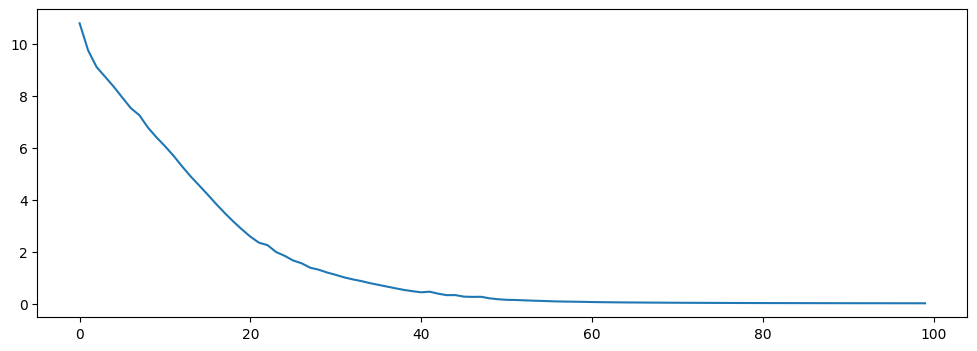

In [64]:
plt.figure(figsize=(12,4))
plt.plot(losses)

In [40]:
class DataLoaderLite:
    def __init__(self, B, T, file_path):
        self.B=B
        self.T=T

        self.batch = lambda x: x.view(B,T)

        with open(file_path, 'r') as f:
            text = f.read()

        enc = tiktoken.get_encoding('gpt2')

        tokens = enc.encode(text)
        self.tokens = Tensor(tokens, dtype=dtypes.long)

        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B*T)} batches")

        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        buf = self.tokens[self.current_position:self.current_position + B*T+1]
        x = self.batch(buf[:-1])
        y = self.batch(buf[1:])
        self.current_position += B*T

        if self.current_position + (B*T+1) > len(self.tokens):
            print("read entire document, resetting position...")
            self.current_position = 0

        return x,y

In [67]:
Tensor.training = True
Tensor.no_grad = False
model = GPT2(GPT2Small)
optim = AdamW(get_parameters(model), lr=3e-4)
dl = DataLoaderLite(4, 32, "../datasets/shake.txt")
losses = []
for i in (t := trange(100)):
    x, y = dl.next_batch() 
    optim.zero_grad()
    logits, loss = model(x,y)
    losses.append(loss.numpy())
    loss.backward()
    optim.step()

    t.set_description(
        f"train loss: {loss.numpy():.2f}"
    )

loaded 338025 tokens
1 epoch = 2640 batches


train loss: 6.71: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


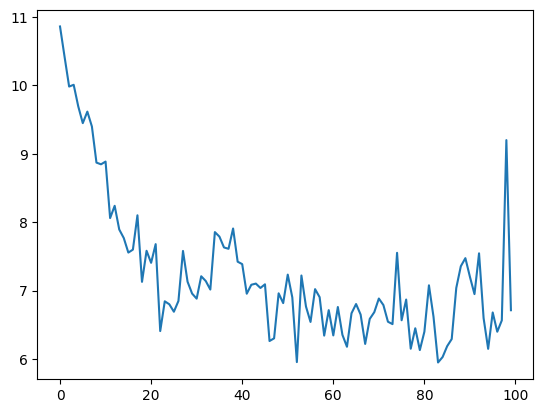

In [68]:
plt.plot(losses)

Sweet! We now have a GPT2 model that we can run with pretrained weights and train.